In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import os
import multiprocessing as mp

from code.models import basicunet, resnetunet
from code.datasets import TGSAugDataset, TGSPairsDataset
from code.configs import *
from code.train import *
from code.losses import FocalRobustLoss, SoftDiceCoef
from code.metrics import *
from code.augmentations import *
from code.utils import *
from torch.utils.data import DataLoader
from IPython.display import clear_output
from code.inference import *

%matplotlib inline

In [2]:
def train_augment(image, mask):
    if np.random.rand() < 0.5:
        image, mask = do_horizontal_flip2(image, mask)

    if mask.sum() == 0:
        if np.random.rand() < 0.6:
            image, mask = do_elastic_transform2(image, mask, grid=10,
                                                distort=np.random.uniform(0, 0.15))
        if np.random.rand() < 0.6:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.2)
        if np.random.rand() < 0.6:
            angle = np.random.uniform(0, 15)
            scale = compute_scale_from_angle(angle * np.pi / 180)
            image, mask = do_shift_scale_rotate2(image, mask, dx=0, dy=0, scale=scale,
                                                 angle=angle)
        if np.random.rand() < 0.6:
            image, mask = do_random_perspective2(image, mask, 0.3)
    else:
        c = np.random.choice(4)
        if c == 0:
            image, mask = do_elastic_transform2(image, mask, grid=10,
                                                distort=np.random.uniform(0, 0.15))
        elif c == 1:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.2)
        elif c == 2:
            angle = np.random.uniform(0, 15)
            scale = compute_scale_from_angle(angle * np.pi / 180)
            image, mask = do_shift_scale_rotate2(image, mask, dx=0, dy=0, scale=scale,
                                                 angle=angle)
        elif c == 3:
            image, mask = do_random_perspective2(image, mask, 0.3)
            
    if np.random.rand() < 0.0:
        c = np.random.choice(3)
        if c == 0:
            image = do_brightness_shift(image, np.random.uniform(-0.1, 0.1))  # 0.05
        elif c == 1:
            image = do_brightness_multiply(image, np.random.uniform(1 - 0.08, 1 + 0.08))  # 0.05
        elif c == 2:
            image = do_gamma(image, np.random.uniform(1 - 0.08, 1 + 0.08))  # 0.05

    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    image, mask = do_resize2(image, mask, 202, 202)
    image, mask = do_center_pad_to_factor2(image, mask, factor=64)
    #image, mask = do_resize2(image, mask, 128, 128)
    
    return image, mask


def flip_augment(image, mask):
    if np.random.rand() < 0.5:
        image, mask = do_horizontal_flip2(image, mask)
    image, mask = do_resize2(image, mask, 202, 202)
    image, mask = do_center_pad_to_factor2(image, mask, factor=64)
    return image, mask


def test_augment(image, mask):
    image, mask = do_resize2(image, mask, 202, 202)
    image, mask = do_center_pad_to_factor2(image, mask, factor=64)
    #image, mask = do_resize2(image, mask, 128, 128)
    return image, mask

In [3]:
train_ds = TGSPairsDataset(augmenter=flip_augment, pairs_path=PATH_TO_PAIRS,
                           path=os.path.join(PATH_TO_SALT_CV, "fold-1/train"), 
                         path_to_depths=PATH_TO_DEPTHS, progress_bar=True)
valid_ds = TGSAugDataset(augmenter=test_augment, path=os.path.join(PATH_TO_SALT_CV, "fold-1/valid"), 
                         path_to_depths=PATH_TO_DEPTHS, progress_bar=True)

In [4]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=16, num_workers=4)

In [5]:
class UNetResNet34Wrapped(resnetunet.UNetResNet34):
    
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.to(device)
        
    def __call__(self, image, **kwargs):
        logits = super().__call__(image)
        return {"logits": logits[:,0]}


class BasicUNetWrapped(basicunet.BasicUNet):
    
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.to(device)
        
    def __call__(self, image, **kwargs):
        image = image.unsqueeze(1)
        logits = super().__call__(image)
        return {"logits": logits[:,0]}


class FocalLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = FocalRobustLoss(gamma=2.0, alpha=0.05)
        
    def forward(self, logits, mask, **kwargs):
        logits = logits[:,26:-26,26:-26].contiguous()
        mask = mask[:,26:-26,26:-26].contiguous()
        loss = self.loss_fn(logits, mask)
        return loss
    
    
class LovaszLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = lovasz_elu
        
    def forward(self, logits, mask, **kwargs):
        logits = logits[:,26:-26,26:-26].contiguous()
        mask = mask[:,26:-26,26:-26].contiguous()
        loss = self.loss_fn(logits, mask)
        return loss
    
    
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = SoftDiceCoef()
        
    def forward(self, logits, mask, **kwargs):
        logits = logits[:,26:-26,26:-26].contiguous()
        mask = mask[:,26:-26,26:-26].contiguous()
        loss = self.loss_fn(logits, mask)
        return loss
    
    
def lossWrapped(logits, mask, **kwargs):
    logits = logits[:,27:-27,27:-27].contiguous()
    mask = mask[:,27:-27,27:-27].contiguous()
    loss = lovasz_elu(logits, mask)
    return loss.item()
    
    
def sigmoid(logits):
    return 1. / (1 + np.exp(-logits))
    

def meanAPWrapped(logits, mask, treashold, **kwargs):
    logits_cpu = logits[:,27:-27,27:-27].cpu().detach().numpy()
    mask_cpu = mask[:,27:-27,27:-27].cpu().detach().numpy()
    return meanAP2d(sigmoid(logits_cpu), mask_cpu, treashold)


def meanIoUWrapped(logits, mask, treashold, **kwargs):
    logits_cpu = logits[:,27:-27,27:-27].cpu().detach().numpy()
    mask_cpu = mask[:,27:-27,27:-27].cpu().detach().numpy()
    return meanIoU2d(sigmoid(logits_cpu), mask_cpu, treashold)

###################################################################

def meanSoftIoUWrapped(logits, mask, **kwargs):
    logits_cpu = logits[:,13:-14,13:-14].cpu().detach().numpy()
    mask_cpu = mask[:,13:-14,13:-14].cpu().detach().numpy()
    return meanSoftIoU2d(sigmoid(logits_cpu), mask_cpu)


def meanAccuracyWrapped(logits, mask, **kwargs):
    logits_cpu = logits[:,13:-14,13:-14].cpu().detach().numpy()
    mask_cpu = mask[:,13:-14,13:-14].cpu().detach().numpy()
    return meanAccuracy2d(sigmoid(logits_cpu), mask_cpu)

In [6]:
from torch.nn import functional as F
from torch.autograd import Variable


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_elu(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_elu_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_elu_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_sigmoid(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz sigmoid loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_sigmoid_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_sigmoid_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]    
    grad = lovasz_grad(gt_sorted)    
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss


def lovasz_elu_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    #if len(labels) == 0:
        # only void pixels, the gradients should be 0
    #    return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]    
    grad = lovasz_grad(gt_sorted)    
    loss = torch.dot(F.elu(errors_sorted) + 1, Variable(grad))
    return loss


def lovasz_sigmoid_flat(logits, labels):
    """
    Binary Lovasz sigmoid loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    errors = (labels - F.sigmoid(logits)).abs()
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]    
    grad = lovasz_grad(gt_sorted)    
    loss = torch.dot(errors_sorted, Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [7]:
device = torch.device("cuda")
model = UNetResNet34Wrapped(device)

In [8]:
loss_fn = DiceLoss()

In [9]:
sum([p.nelement() for p in model.parameters()]) - sum([p.nelement() for p in model.resnet.parameters()])

5422145

In [10]:
#model.load_pretrain(PATH_TO_RESNET34)

In [11]:
#optim = torch.optim.SGD(model.parameters(), momentum=0.9, weight_decay=0.0001, lr=0.005)
#optim = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)
#optim = torch.optim.Adam([
#    {"params": net.resnet.parameters(), "lr": 0.0001},
#    {"params": net.center.parameters(), "lr": 0.001},
#    {"params": net.decoder1.parameters(), "lr": 0.001},
#    {"params": net.decoder2.parameters(), "lr": 0.001},
#    {"params": net.decoder3.parameters(), "lr": 0.001},
#    {"params": net.decoder4.parameters(), "lr": 0.001},
#    {"params": net.decoder5.parameters(), "lr": 0.001},
#    {"params": net.logit.parameters(), "lr": 0.001},
#])

In [10]:
logger = CSVLogger("log6.txt", ["epoch", "train_loss", "valid_loss",
                                "train_mAP_0.4", "train_mAP_0.5", "train_mAP_0.6", "train_mAP_0.7",
                                "train_mIoU_0.4", "train_mIoU_0.5", "train_mIoU_0.6", "train_mIoU_0.7",
                                "valid_mAP_0.4", "valid_mAP_0.5", "valid_mAP_0.6",  "valid_mAP_0.7", 
                                "valid_mIoU_0.4", "valid_mIoU_0.5", "valid_mIoU_0.6", "valid_mIoU_0.7"], 
                   log_time=True)

In [11]:
mAP_cp = BestLastCheckpointer("mAP1")
mAP_cp.load("best", model=model)
None

In [12]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [13]:
get_learning_rate(optim)

[0.0001]

In [14]:
mAP_cp = BestLastCheckpointer("mAP1.1")
#mSoftIoU_cp = BestLastCheckpointer("mSoftIoU")
mIoU_cp = BestLastCheckpointer("mIoU1.1")
#acc_cp = BestLastCheckpointer("Acc")

In [17]:
#freeze(model.resnet)

In [18]:
#freeze(model, include=(torch.nn.BatchNorm2d,))

In [ ]:
logger.resetClock()
for epoch in range(20):
    print("Epoch:", epoch)
    
    loss = train_epoch_fn(model, train_dl, optim, loss_fn, verbose=1, loss_file="lovasz_loss.txt")
    
    train_metrics = eval_fn(model, train_dl, 
            {
                "train_loss": lossWrapped, 
                "train_mAP_0.4": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.4), 
                "train_mAP_0.5": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.5), 
                "train_mAP_0.6": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.6), 
                "train_mAP_0.7": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.7), 
                "train_mIoU_0.4": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.4), 
                "train_mIoU_0.5": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.5), 
                "train_mIoU_0.6": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.6), 
                "train_mIoU_0.7": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.7), 
            }, 
            verbose=1)
    valid_metrics = eval_fn(model, valid_dl, 
            {
                "valid_loss": lossWrapped, 
                "valid_mAP_0.4": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.4), 
                "valid_mAP_0.5": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.5), 
                "valid_mAP_0.6": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.6), 
                "valid_mAP_0.7": lambda logits, mask, **kwargs: meanAPWrapped(logits, mask, 0.7), 
                "valid_mIoU_0.4": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.4), 
                "valid_mIoU_0.5": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.5), 
                "valid_mIoU_0.6": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.6), 
                "valid_mIoU_0.7": lambda logits, mask, **kwargs: meanIoUWrapped(logits, mask, 0.7), 
            }, 
                            verbose=1)
    
    logger.write(epoch=epoch, **train_metrics, **valid_metrics)
    
    mAP_cp.update(-max(valid_metrics["valid_mAP_0.4"], 
                       valid_metrics["valid_mAP_0.5"], 
                       valid_metrics["valid_mAP_0.6"],
                       valid_metrics["valid_mAP_0.7"]), 
                    model=model, optim=optim, epoch=epoch)
    mIoU_cp.update(-max(valid_metrics["valid_mIoU_0.4"], 
                       valid_metrics["valid_mIoU_0.5"], 
                       valid_metrics["valid_mIoU_0.6"],
                       valid_metrics["valid_mIoU_0.7"]),
                    model=model, optim=optim, epoch=epoch)
    
    clear_output()

Epoch: 6


In [ ]:
# 10 epoch Adam lr=0.001 wd=0.0001 decoder focal loss
# 20 epoch Adam lr=0.0001 wd=0.0001 focal loss
# 20 + 30 + 30 epoch Adam lr=0.0001 wd=0.0001 lovasz loss
# freeze bn, wo color aug, 30 epoch Adam lr=0.0001 wd=0.0001 lovasz loss
# freeze bn, wo color aug, 30 epoch Adam lr=0.00001 wd=0.0001 lovasz loss

In [17]:
unfreeze(model)

In [21]:
set_learning_rate(optim, 0.00001)

In [16]:
freeze(model, include=(torch.nn.BatchNorm2d,))

In [22]:
get_learning_rate(optim)

[1e-05]

In [ ]:
# 15: decoder only, Adam, lr = 0.0001
# 35: Adam, lr = 0.0001
# 10: Adam, lr = 0.00001
# 10: freeze BN, Adam, lr = 0.00001
# 10: wo color aug, Adam, lr = 0.00001
# 20: wo dropout, Adam, lr = 0.00001

In [51]:
mAP_cp.load("best", model=model)
None

In [16]:
predict_and_save(model, valid_dl, ["proba"], "id", "valid", verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [120]:
probs, ids = load_pred_probs("valid/proba", verbose=1)

In [44]:
def load_masks(path, ids=None):
    if ids is None:
        ids = [name.split(".")[0] for name in os.listdir(path)]
    masks = [read_mask(os.path.join(path, id_ + ".png")) for id_ in ids]
    return np.stack(masks)

def load_images(path, ids=None):
    if ids is None:
        ids = [name.split(".")[0] for name in os.listdir(path)]
    images = [read_image(os.path.join(path, id_ + ".png")) for id_ in ids]
    return np.stack(images)

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [121]:
masks = load_masks(os.path.join(PATH_TO_SALT_CV, "fold-1/valid/masks"), ids)

In [49]:
images = load_images(os.path.join(PATH_TO_SALT_CV, "fold-1/valid/images"), ids)

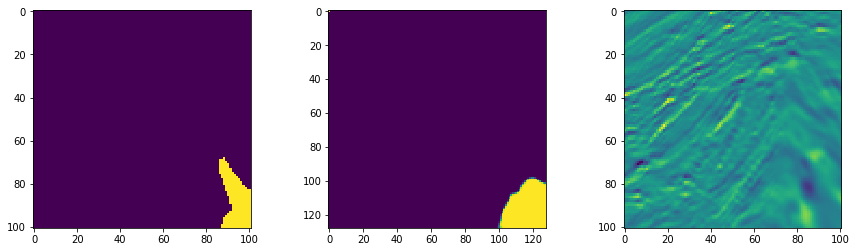

In [108]:
id_ = 550

plt.figure(figsize=[15, 4])
plt.subplot(1, 3, 1)
plt.imshow(masks[id_])
plt.subplot(1, 3, 2)
m = sigmoid(probs[id_])
m[0,0] = 1
plt.imshow(m)
plt.subplot(1, 3, 3)
plt.imshow(images[id_])

In [89]:
idx = np.argsort(masks.sum(axis=(1, 2)))

In [102]:
idx[350:360]

array([703, 207, 200, 545, 460, 724, 688,  75, 550,   2])

In [122]:
p = [do_resize2(m,m,101,101)[1] for m in probs]
p = np.stack(p)

In [123]:
scores = []
for t in tqdm_notebook(np.linspace(0, 1, 100)):
    scores.append(meanAP2d(p > t, masks))

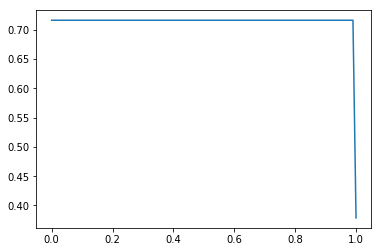

In [124]:
plt.plot(np.linspace(0, 1, 100), scores)

In [126]:
valid_metrics = eval_fn(model, valid_dl, 
            {"valid_mAP": meanAPWrapped, "valid_mIoU": meanIoUWrapped, 
             "valid_mSoftIoU": meanSoftIoUWrapped, "valid_mAcc": meanAccuracyWrapped}, 
                            verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [127]:
valid_metrics

{'valid_mAP': 0.7142857142857144,
 'valid_mAcc': 0.9467750082210619,
 'valid_mIoU': 0.7593747121947152,
 'valid_mSoftIoU': 0.3854562944295455}

In [17]:
f = lambda x, **kw: 2*x

In [20]:
f(2, d=1)

4

In [29]:
torch.cuda.empty_cache()

In [32]:
save_checkpoint("last.pth", model=model, optim=optim)

In [17]:
test_ds = TGSAugDataset(augmenter=test_augment, path=PATH_TO_TEST, 
                        path_to_depths=PATH_TO_DEPTHS, progress_bar=True)

In [18]:
test_dl = DataLoader(test_ds, batch_size=16, num_workers=4)

In [52]:
predict_and_save(model, test_dl, ["logits"], "id", "test2", verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [53]:
logits, ids = load_pred_probs("test2/logits/", verbose=1)

In [54]:
preds = (logits > 0).astype(int)

In [55]:
preds = preds[:,13:-14,13:-14]

In [56]:
((preds.sum(axis=(1, 2)) > 0) & (preds.sum(axis=(1, 2)) < 10)).mean()

0.0026666666666666666

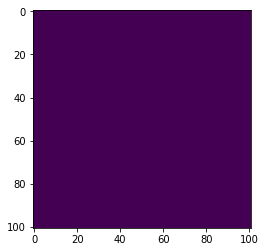

In [57]:
plt.imshow(preds[10])

In [58]:
preds = force_zero_empty(os.path.join(PATH_TO_TEST, "images"), ids, preds, verbose=1)

In [59]:
prepare_submit(preds, ids, "smbt34.csv")

In [60]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f smbt34.csv -m "ResNet34 Lovasz best cp"

Successfully submitted to TGS Salt Identification Challenge